# Optymalizacja reguły PPMF 

In [72]:
library(tidyverse)
library(magrittr)
library(furrr)
library(here)
library(gghighlight)
library(latex2exp)
library(scales)


value_plot = function(.data, .tupper=NA, .f=base::identity) {
  max_value = max(.data$func_val_best, .data$func_val_mean) 
  .data %>% 
    ggplot2::ggplot(aes(x = t)) +
    ggplot2::geom_point(aes(y = .f(func_val_best), shape = method, color = method), size = 1) + 
    ggplot2::geom_line(aes(y = .f(func_val_best), color = method, linetype = method), size = 2) + 
    ggplot2::scale_colour_brewer(palette="Dark2") +
    ggplot2::scale_y_continuous(
        trans = 'log10',
        breaks = scales::trans_breaks("log10", function(x) 10^x),
        labels = scales::trans_format("log10", math_format(10^.x, 2))
      ) +   
    ggplot2::xlim(0, ifelse(missing(.tupper), NA, .tupper)) +
    xlab("t") +
    ylab(latex2exp::TeX("$|q_{best}|$")) + 
    theme_bw() +
    theme(
        plot.title = element_text(size = 15, face = "bold"),
        axis.title = element_text(size = 15, face = "bold"),
        legend.background=element_blank(),
        axis.text = element_text(size = 15, face = "bold"),
        legend.text = element_text(size = 15, face = "bold"),
        legend.title = element_text(size = 15, face = "bold")
    )

}


options(repr.plot.width=10, repr.plot.height=10)

In [74]:
source(here::here("src", "alg-exp", "cma-es-csa.R"))
source(here::here("src", "alg-exp", "cma-es-expth.R"))
source(here::here("src", "exp-utils.R"))
source(here::here("src", "data-utils.R"))
source(here::here("src", "plot-funcs.R"))
#source(here::here("src", "eval-funcs.R"))
alog10 = . %>% abs() %>% log10()

In [32]:
eval_func = 
    . %>% crossprod(.) 

# "Fabryka" CMA-ESów
expth_factory = function(d_params, p_targets) {
    expand.grid(
        d_param = d_params,
        p_target = p_targets
    ) %>%
    purrr::pmap(function(d_param, p_target) {
     purrr::partial(cma_es_expth, d_param = d_param, p_target = p_target)    
    })
}


rename_algs = function(dfx) {
    dfx %>%
    dplyr::mutate(
        method = ifelse(method == "cma-es-csa", "CMA-ES-CSA", 
                      ifelse(method == "cma-es-msr", "CMA-ES-MSR", 
                            ifelse(method == "cma-es-quant", "CMA-ES-CPMF",
                                  ifelse(method == "cma-es-ja", "CMA-ES-PPMF",
                                        ifelse(method == "cma-es-expth", "CMA-ES-CPEF", 5)))))
    )
}

In [33]:
d_params = 
    c(0.1, 0.3, 0.5, 0.8, 0.9, 2)

p_targets = 
    c(0.1, 0.25, 0.5, 0.75, 0.95)

In [34]:
# Lista zawierająca funkcje cma_es_expth z różnymi wartościami parametrów

expths =
    expth_factory(d_params, p_targets)

In [35]:
expths %>% length()

[1] 30

## D = 10 & Func = sphere

In [36]:
experiments_d10 = 
    do_experiment(
        methods = c(cma_es_csa, expths),
        func = eval_func,
        dim = 10,
        x0 = 100,
        lower = -100,
        upper = 100
    )

In [93]:
experiments_d30 = 
    do_experiment(
        methods = c(cma_es_csa, expths),
        func = eval_func,
        dim = 50,
        x0 = 100,
        lower = -100,
        upper = 100
    )

Warning message in mccollect(jobs = jobs, wait = TRUE):
“1 parallel job did not deliver a result”


Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
label_key: method



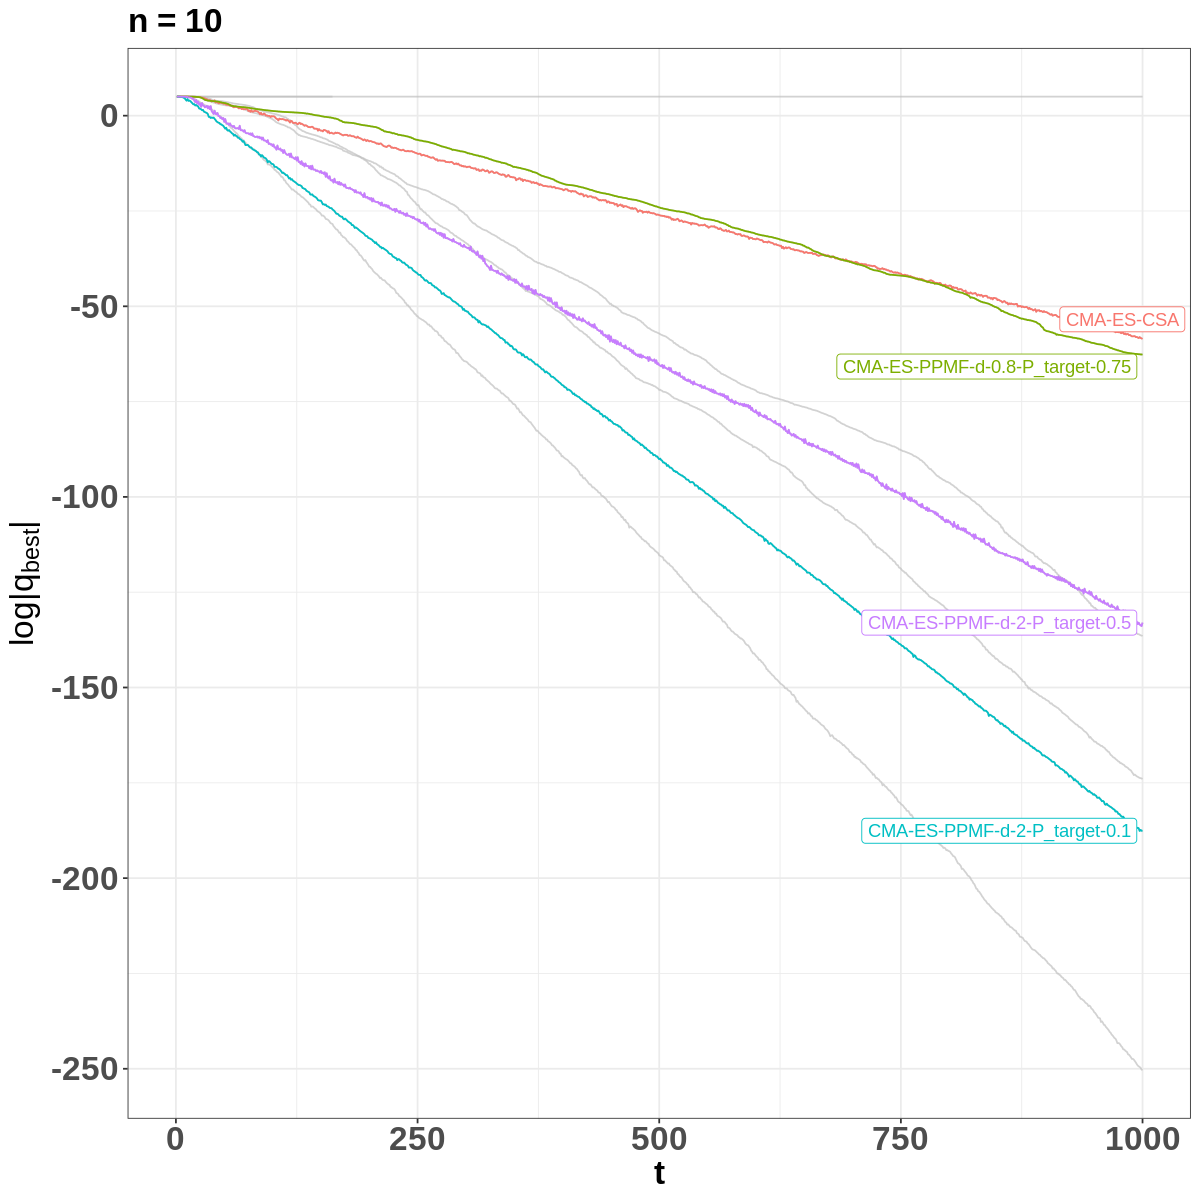

In [91]:
experiments_d10 %>%
    dplyr::mutate(method = ifelse(method == "cma-es-csa", "CMA-ES-CSA", method)) %>%
    dplyr::filter(t <= 1000, method %in% c("CMA-ES-CSA","CMA-ES-PPMF-d-2-P_target-0.5","CMA-ES-PPMF-d-0.1-P_target-0.95", "CMA-ES-PPMF-d-2-P_target-0.1",  "CMA-ES-PPMF-d-0.5-P_target-0.5" ,"CMA-ES-PPMF-d-2-P_target-0.95", "CMA-ES-PPMF-d-0.3-P_target-0.75", "CMA-ES-PPMF-d-0.5-P_target-0.75", "CMA-ES-PPMF-d-0.8-P_target-0.75")) %>%
  #  dplyr::rename(Algorytm = method) %>%
    value_plot(.f = alog10) +
    gghighlight::gghighlight(method %in% c("CMA-ES-CSA","CMA-ES-PPMF-d-2-P_target-0.5", "CMA-ES-PPMF-d-2-P_target-0.1", "CMA-ES-PPMF-d-0.8-P_target-0.75"), use_direct_label = T) +
    ggtitle("n = 10") +
    ylab(latex2exp::TeX("$log|q_{best}|$")) +
    xlab("t") +
     theme(
        plot.title = element_text(size = 20, face = "bold"),
        axis.title = element_text(size = 20, face = "bold"),
        axis.text = element_text(size = 20, face = "bold"),
        legend.background=element_blank(),
        legend.text = element_text(size = 20, face = "bold"),
        legend.title = element_text(size = 20, face = "bold")
    )
   

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
label_key: method



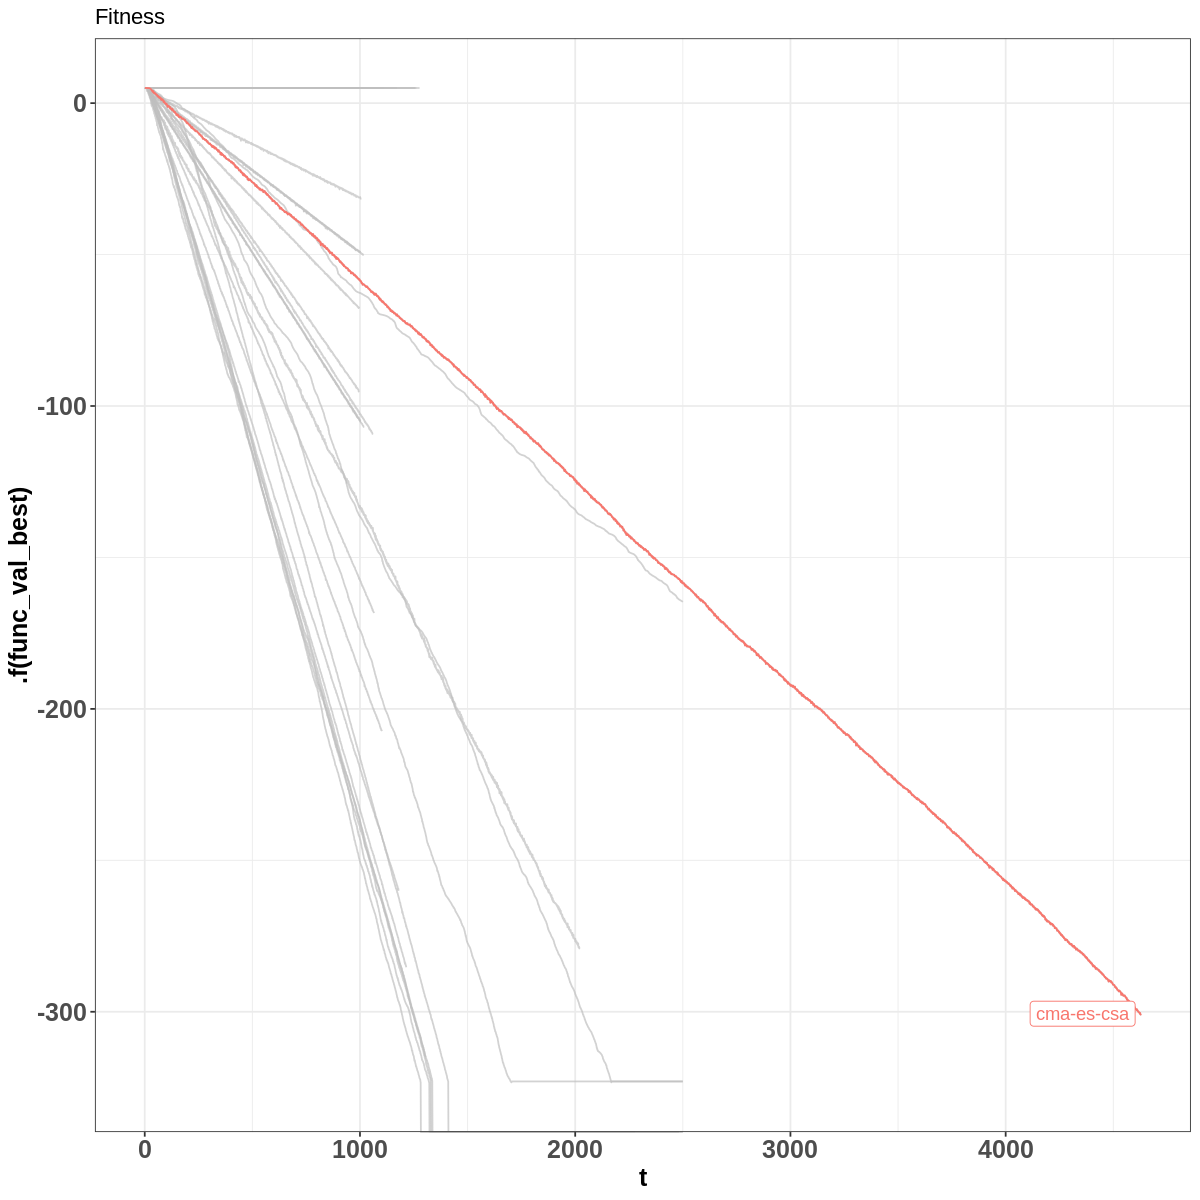

In [87]:
experiments_d10 %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-expth-dp-0.3-pt-0.25", "cma-es-csa", "cma-es-expth-dp-0.8-pt-0.75"), use_direct_label = T) 

## D = 30 & Func = sphere

In [34]:
experiments_d30 = 
    do_experiment(
        methods = c(cma_es_csa, expths),
        func = eval_func,
        dim = 30,
        x0 = 100,
        lower = -100,
        upper = 100
    )

Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preser

label_key: method


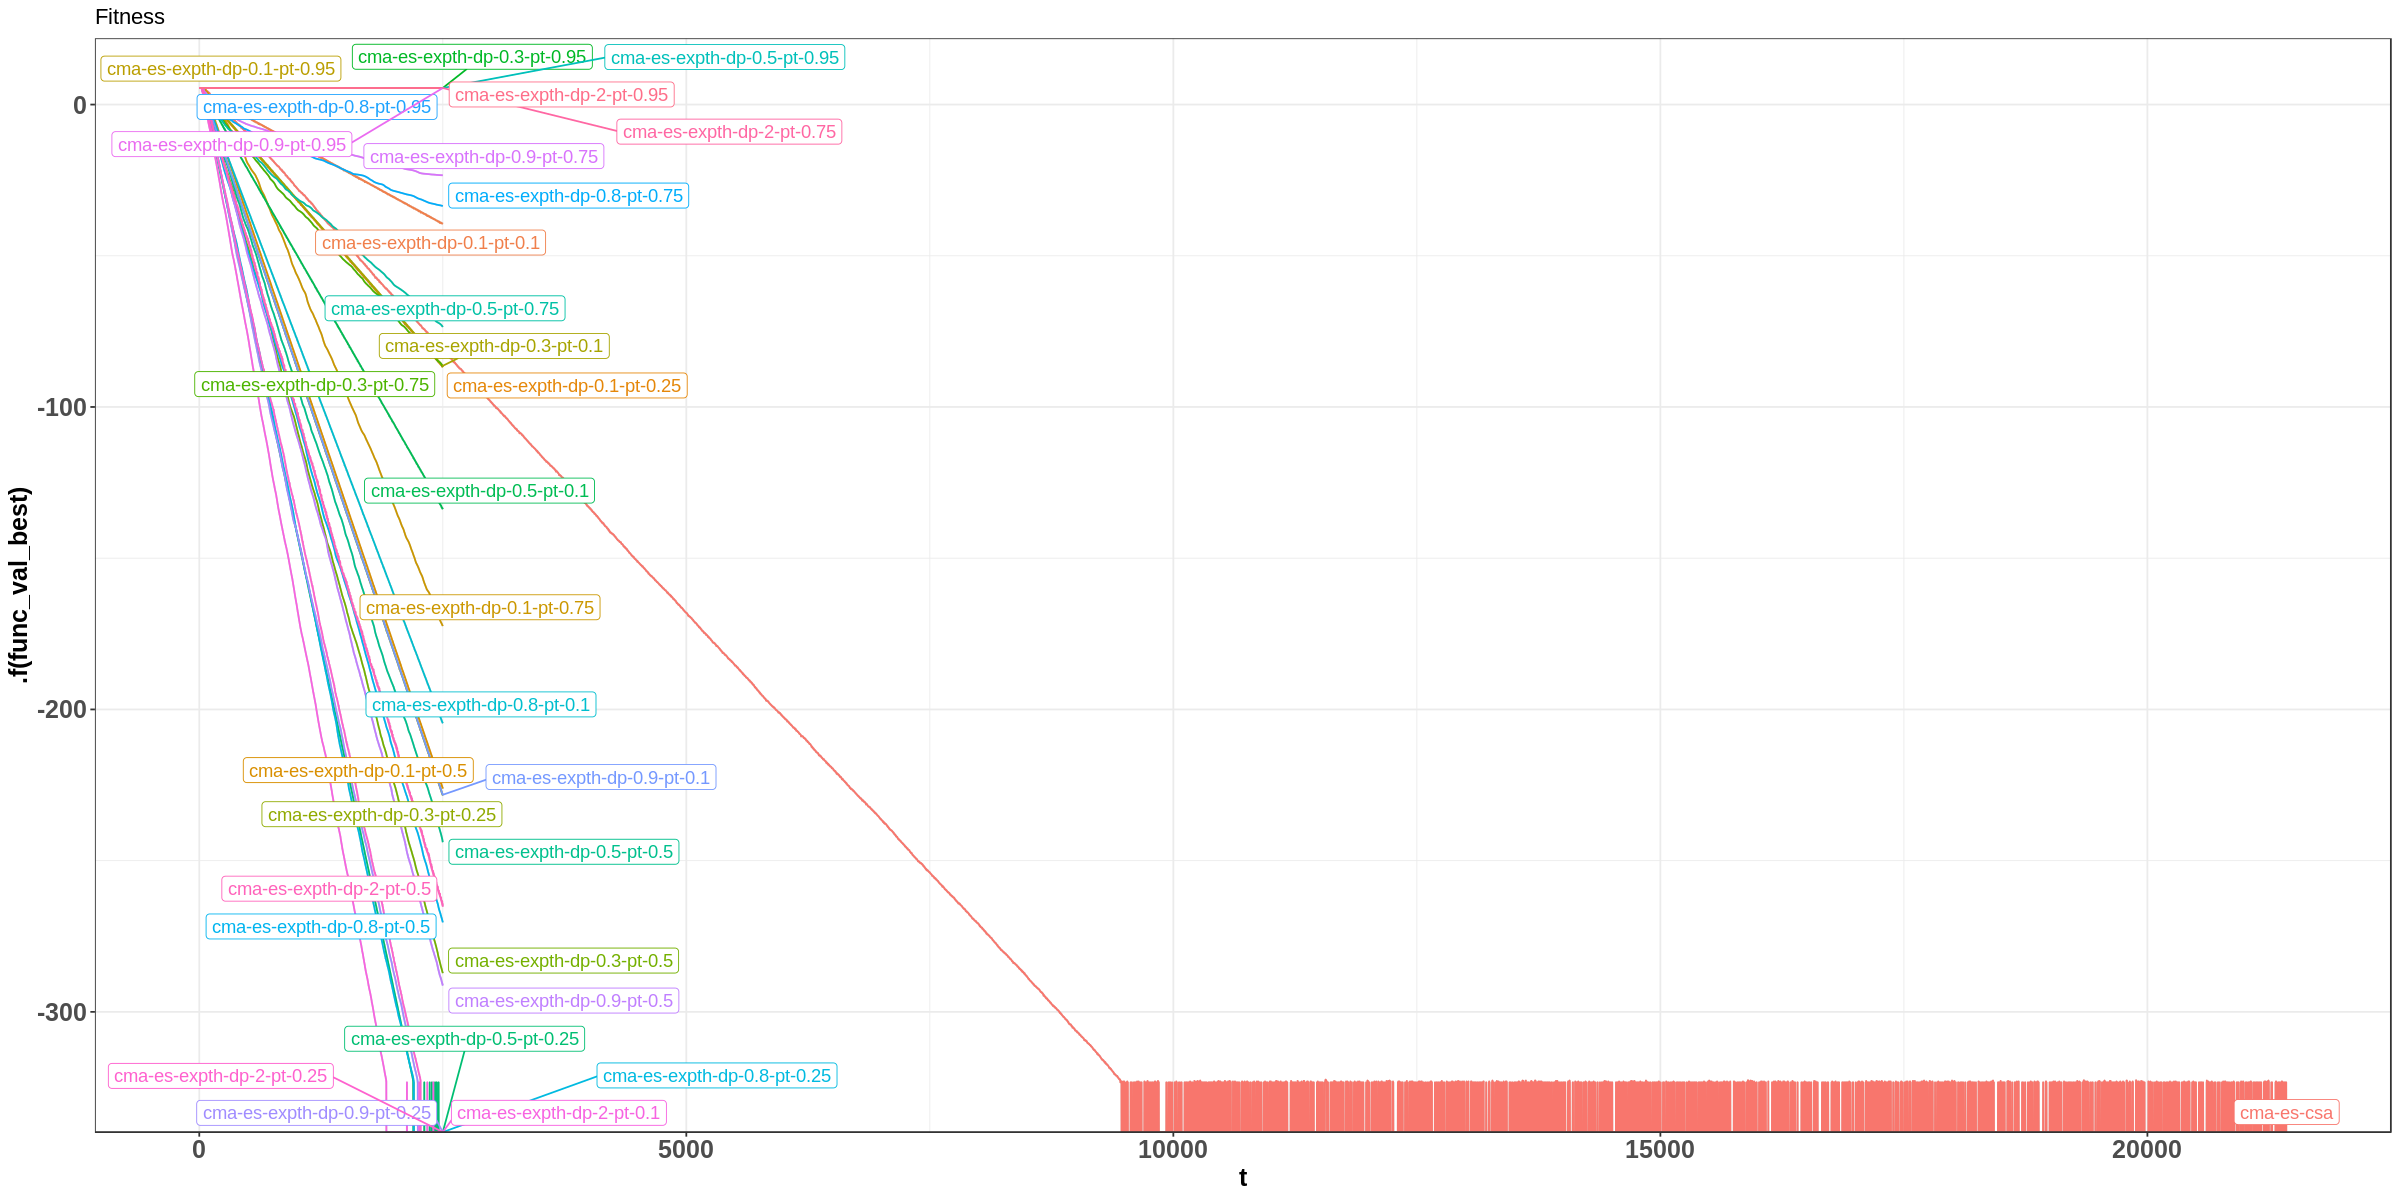

In [35]:
experiments_d30 %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(is.character(method), use_direct_label = T)
    

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


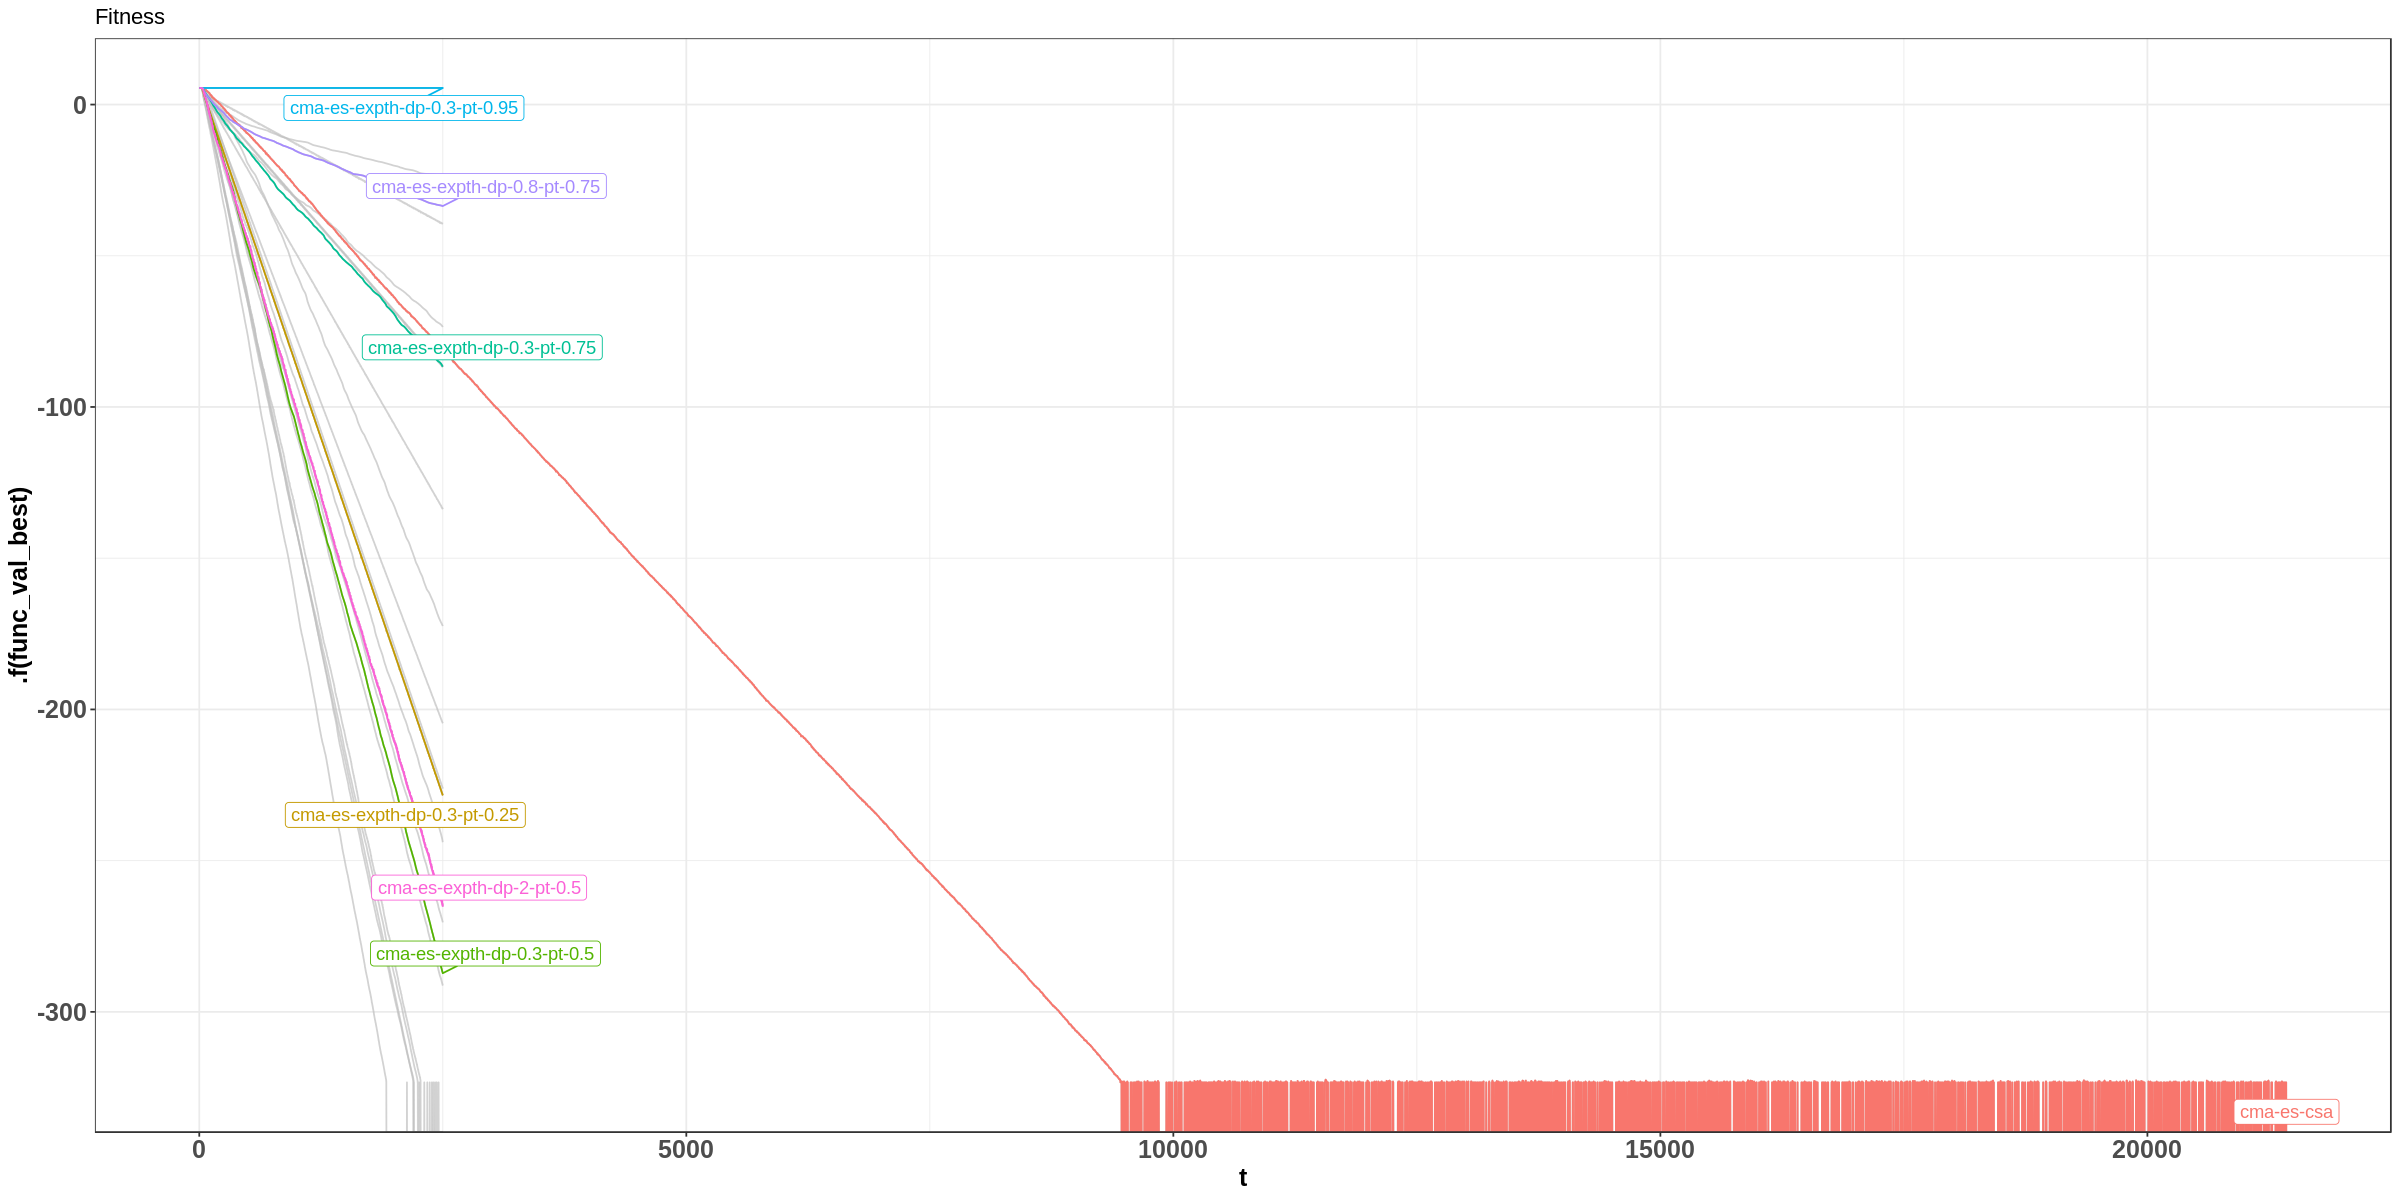

In [99]:
experiments_d30 %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-expth-dp-0.3-pt-0.25", "cma-es-csa", "cma-es-expth-dp-0.3-pt-0.95", "cma-es-expth-dp-0.3-pt-0.75", "cma-es-expth-dp-0.3-pt-0.5", "cma-es-expth-dp-2-pt-0.5", "cma-es-expth-dp-0.8-pt-0.75"), use_direct_label = T) 

## D = 10 & Func = Rastrigin

In [69]:
experiments_d10_rastr = 
    do_experiment(
        methods = c(cma_es_csa, expths),
        func = rastrigin_func,
        dim = 10,
        x0 = 100,
        lower = -100,
        upper = 100
    )

Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preser

label_key: method


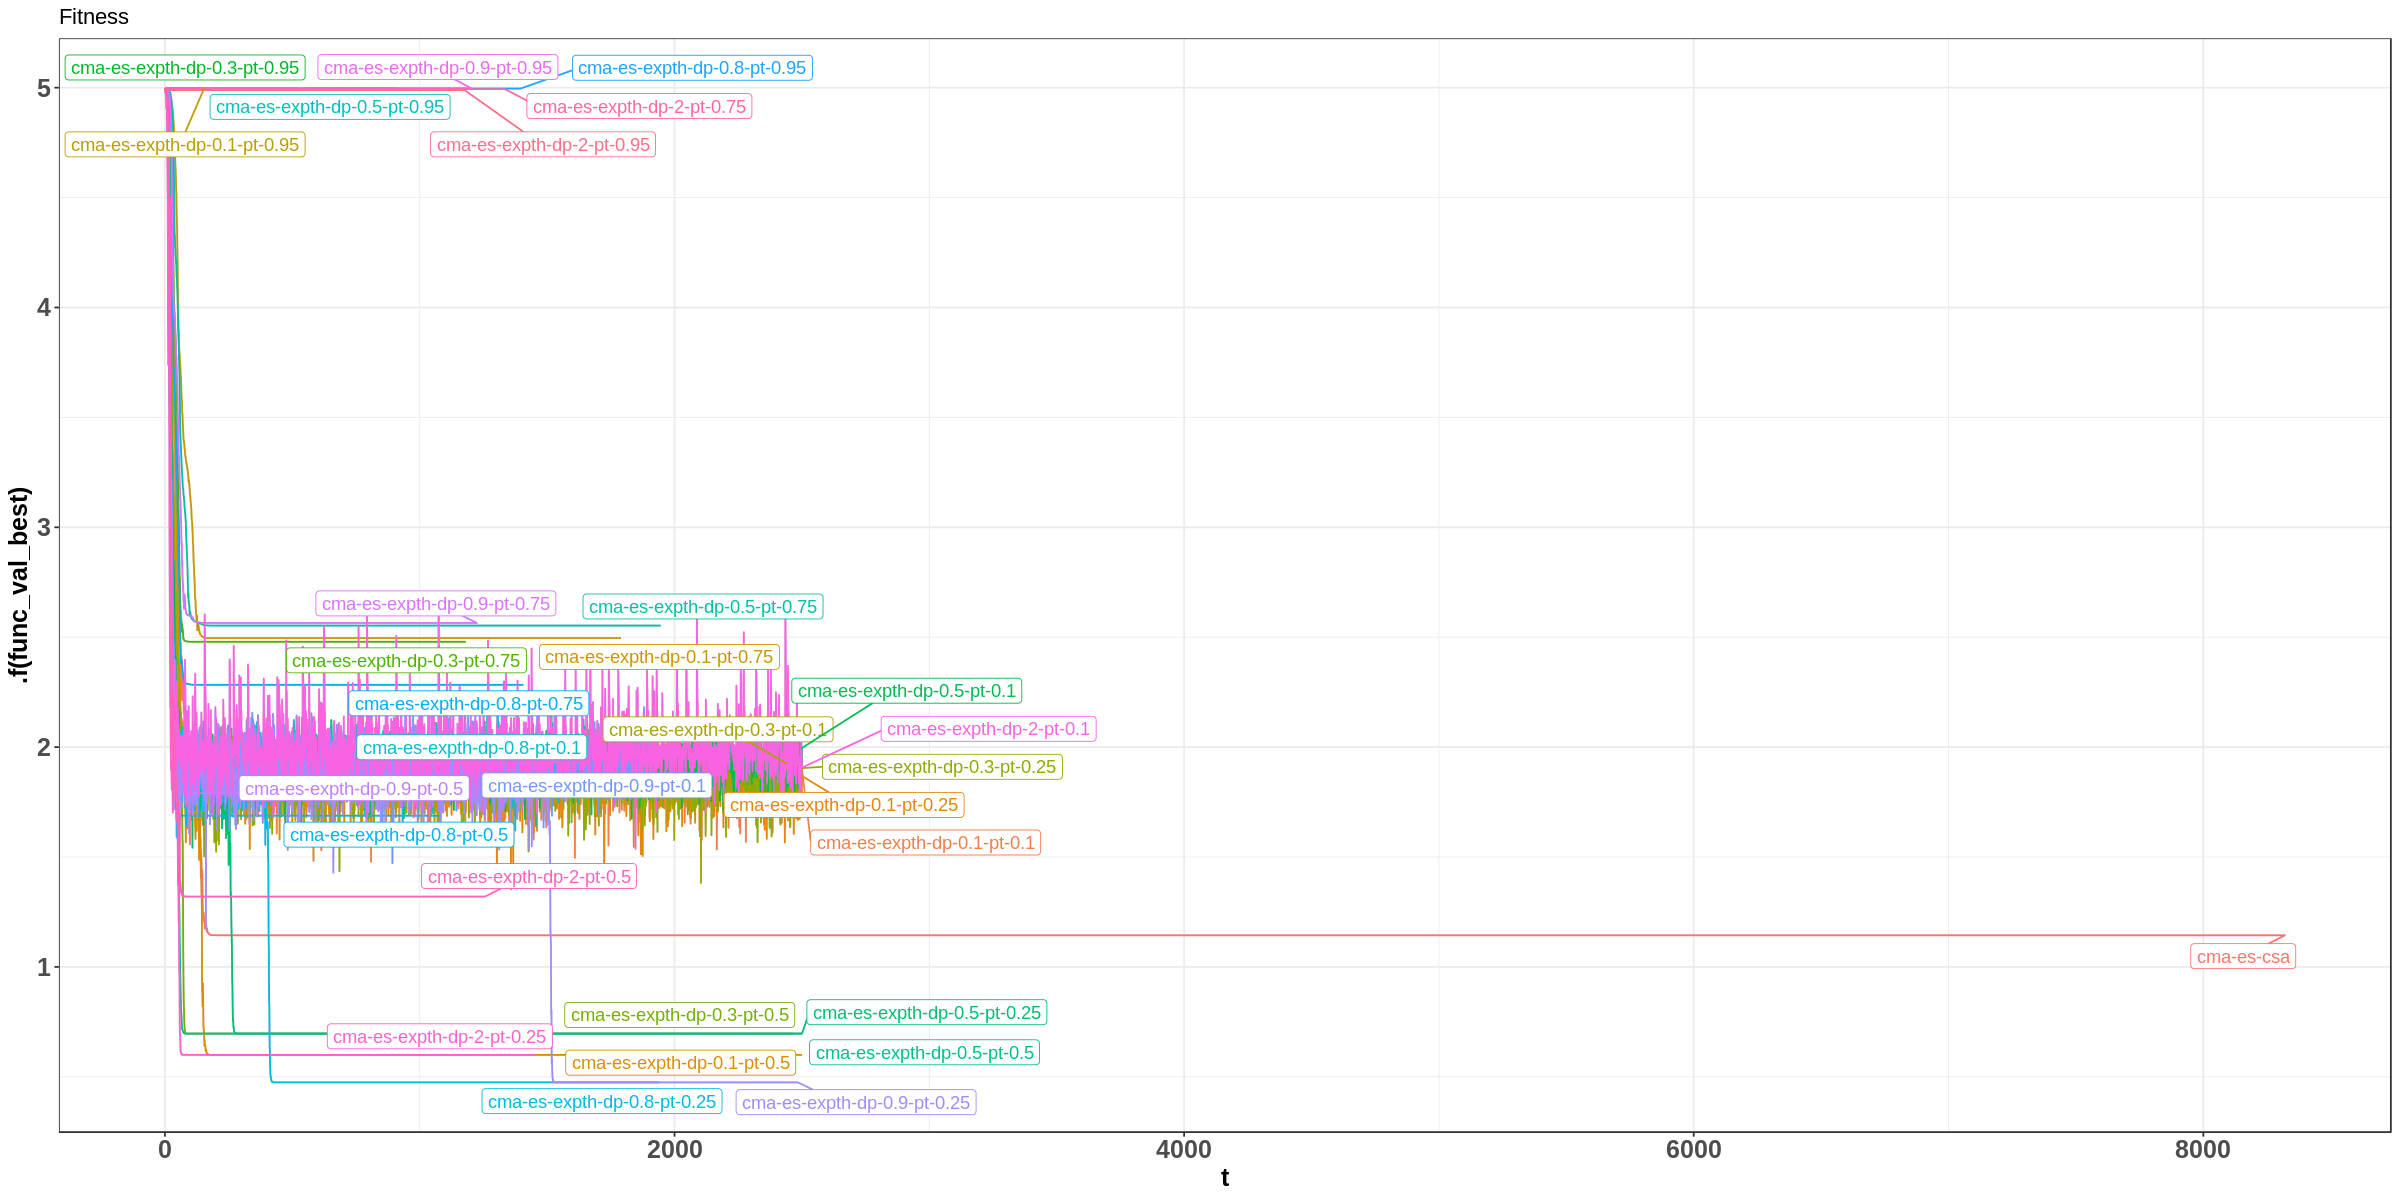

In [48]:
experiments_d10_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(is.character(method), use_direct_label = T)
   

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


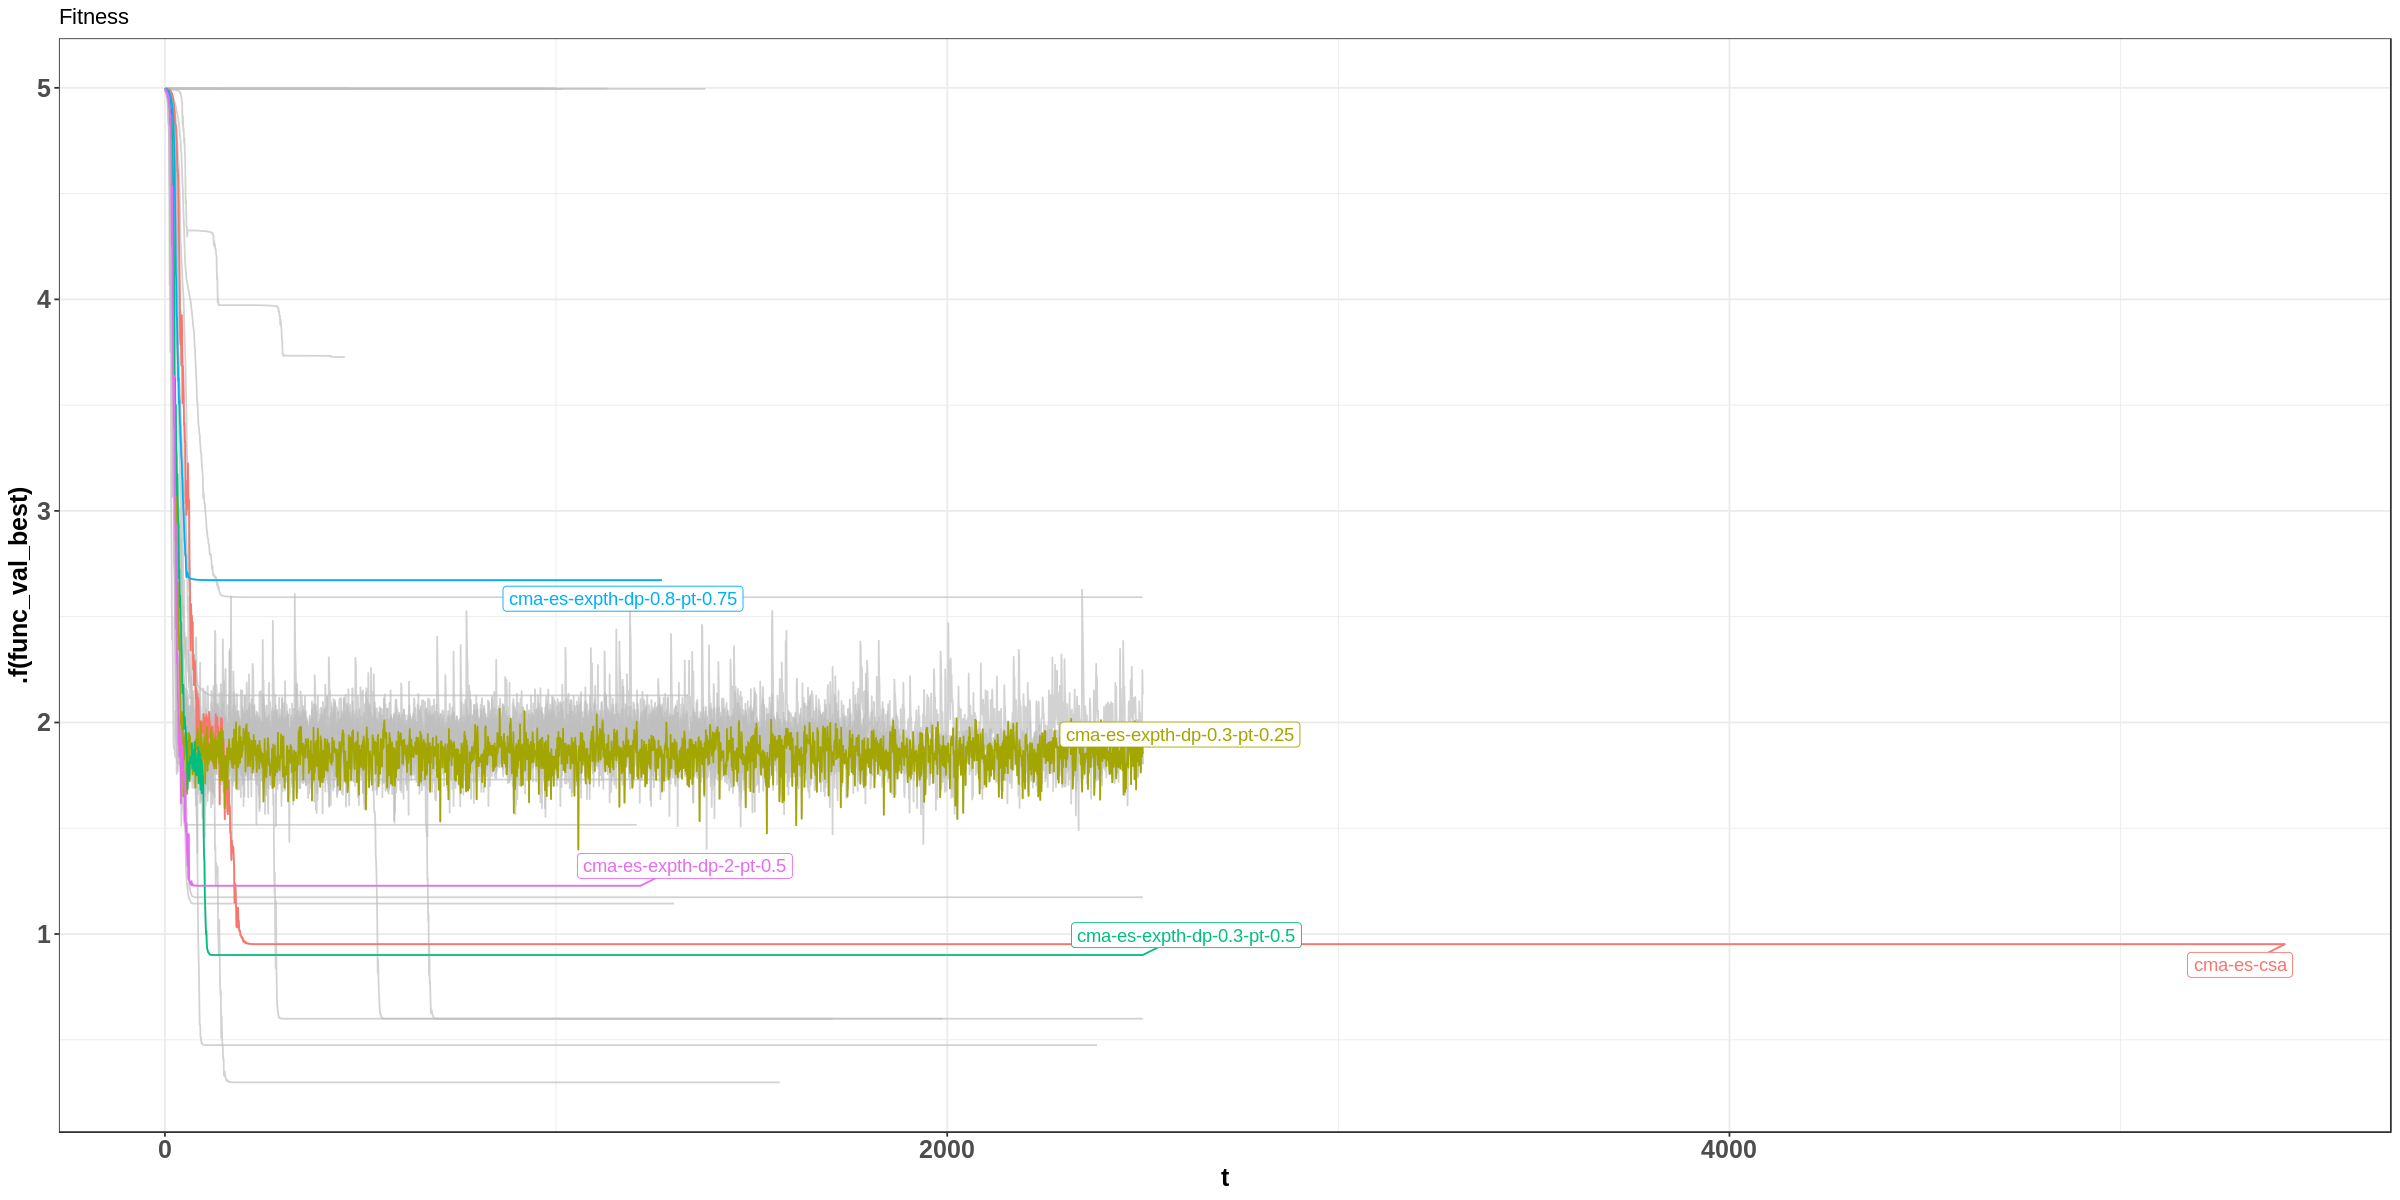

In [94]:
experiments_d10_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-expth-dp-0.3-pt-0.25", "cma-es-csa", "cma-es-expth-dp-0.3-pt-0.5", "cma-es-expth-dp-2-pt-0.5", "cma-es-expth-dp-0.8-pt-0.75"), use_direct_label = T) 

## D = 30 & Func = Rastrigin

In [89]:
experiments_d30_rastr = 
    do_experiment(
        methods = c(cma_es_csa, expths),
        func = rastrigin_func,
        dim = 30,
        x0 = 100,
        lower = -100,
        upper = 100
    )

Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in bind_rows_(x, .id):
“Vectorizing 'glue' elements may not preser

label_key: method


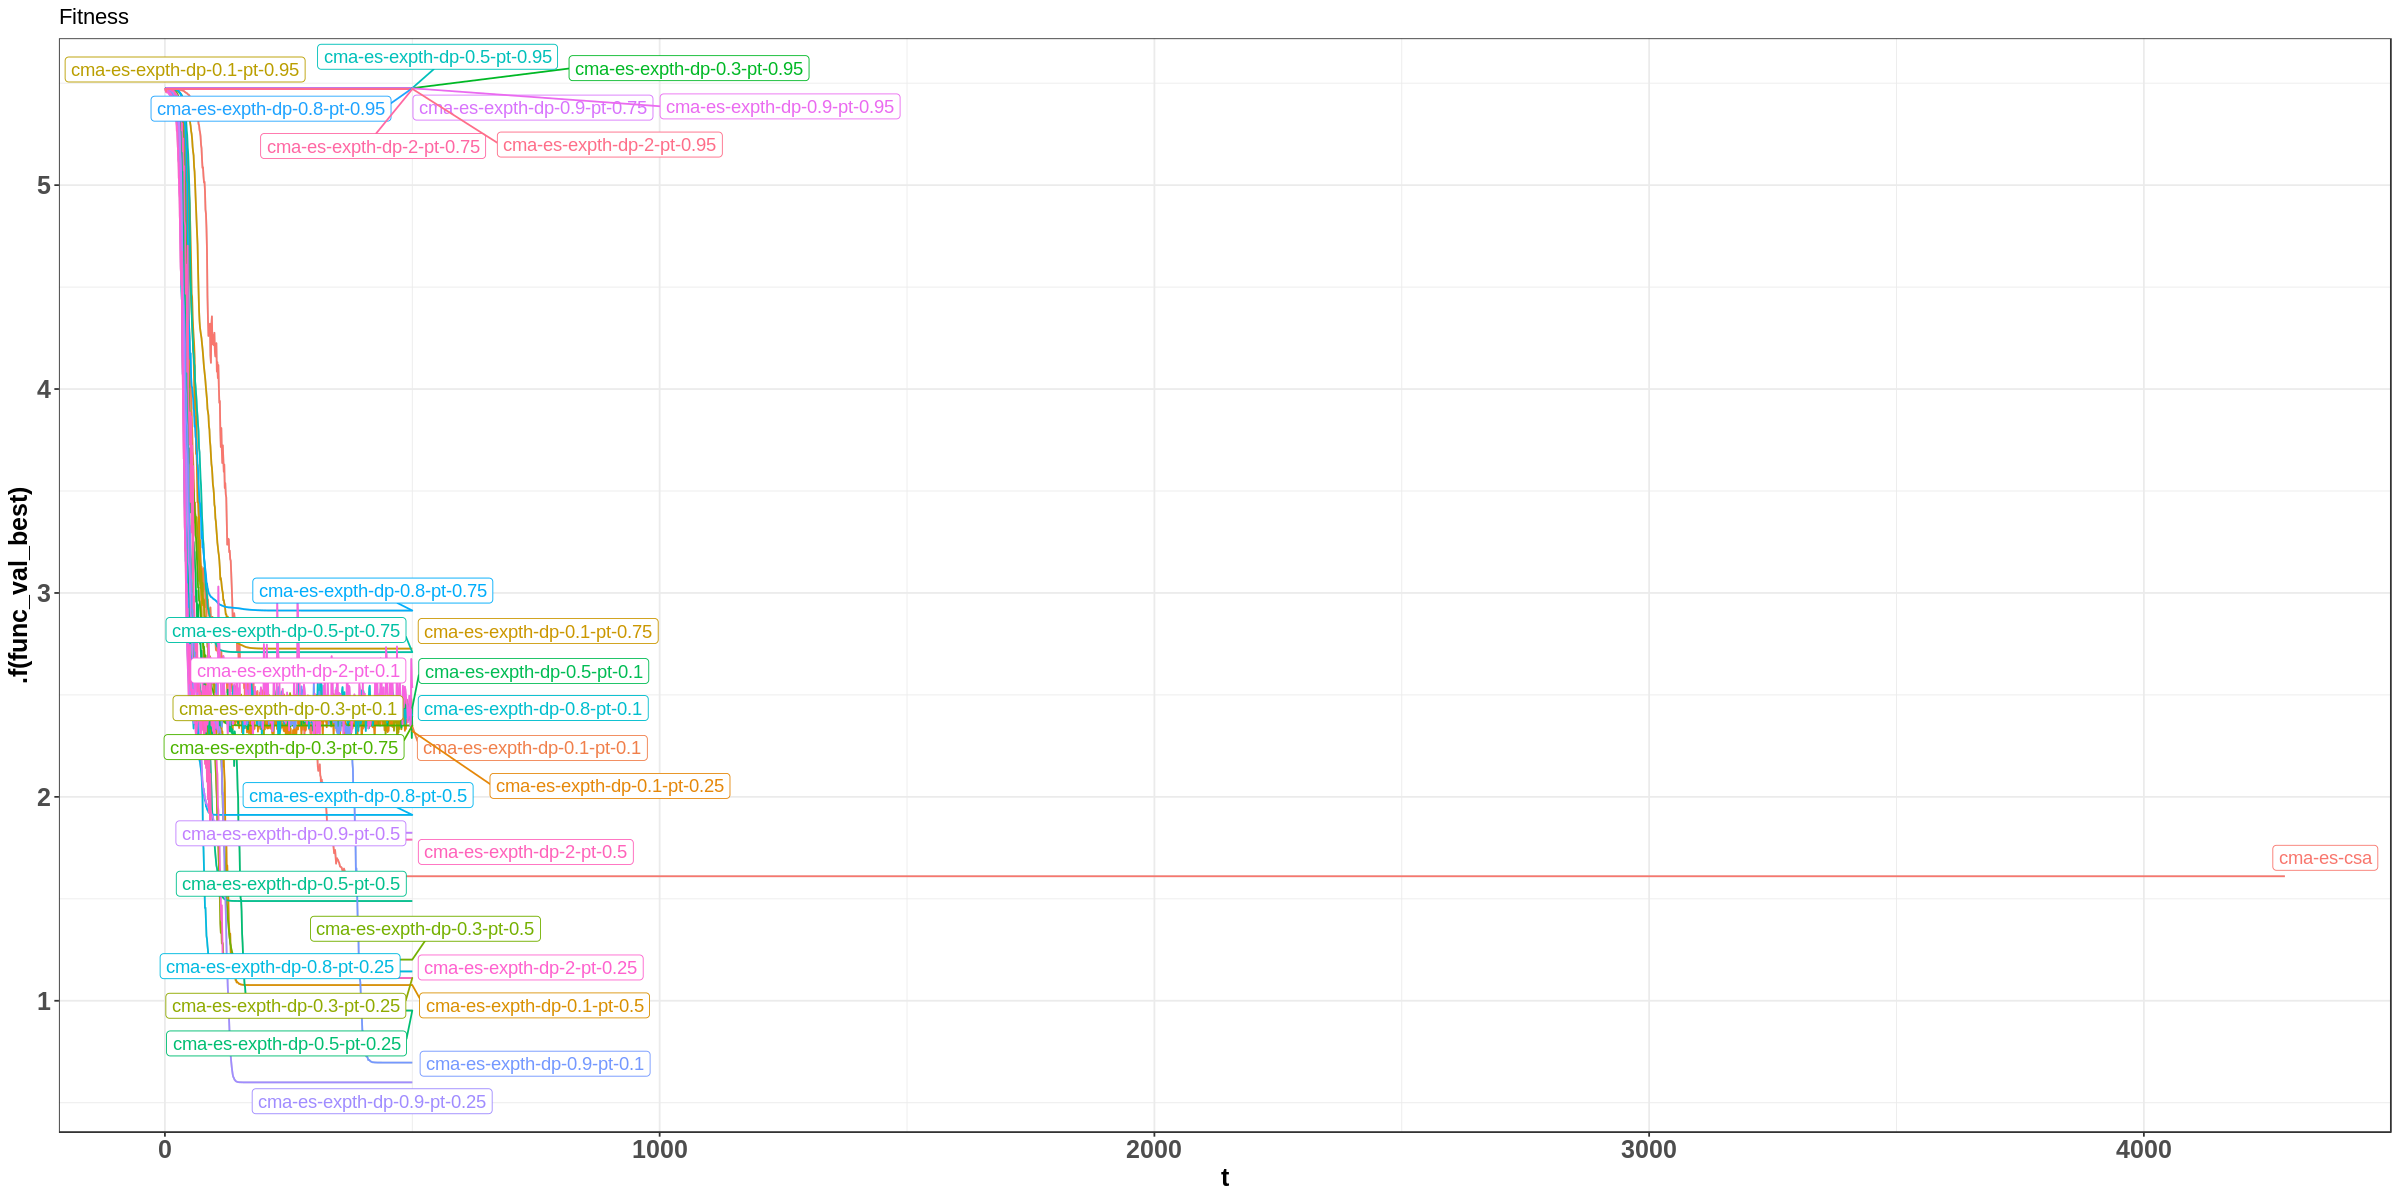

In [90]:
experiments_d30_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(is.character(method), use_direct_label = T)
    

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


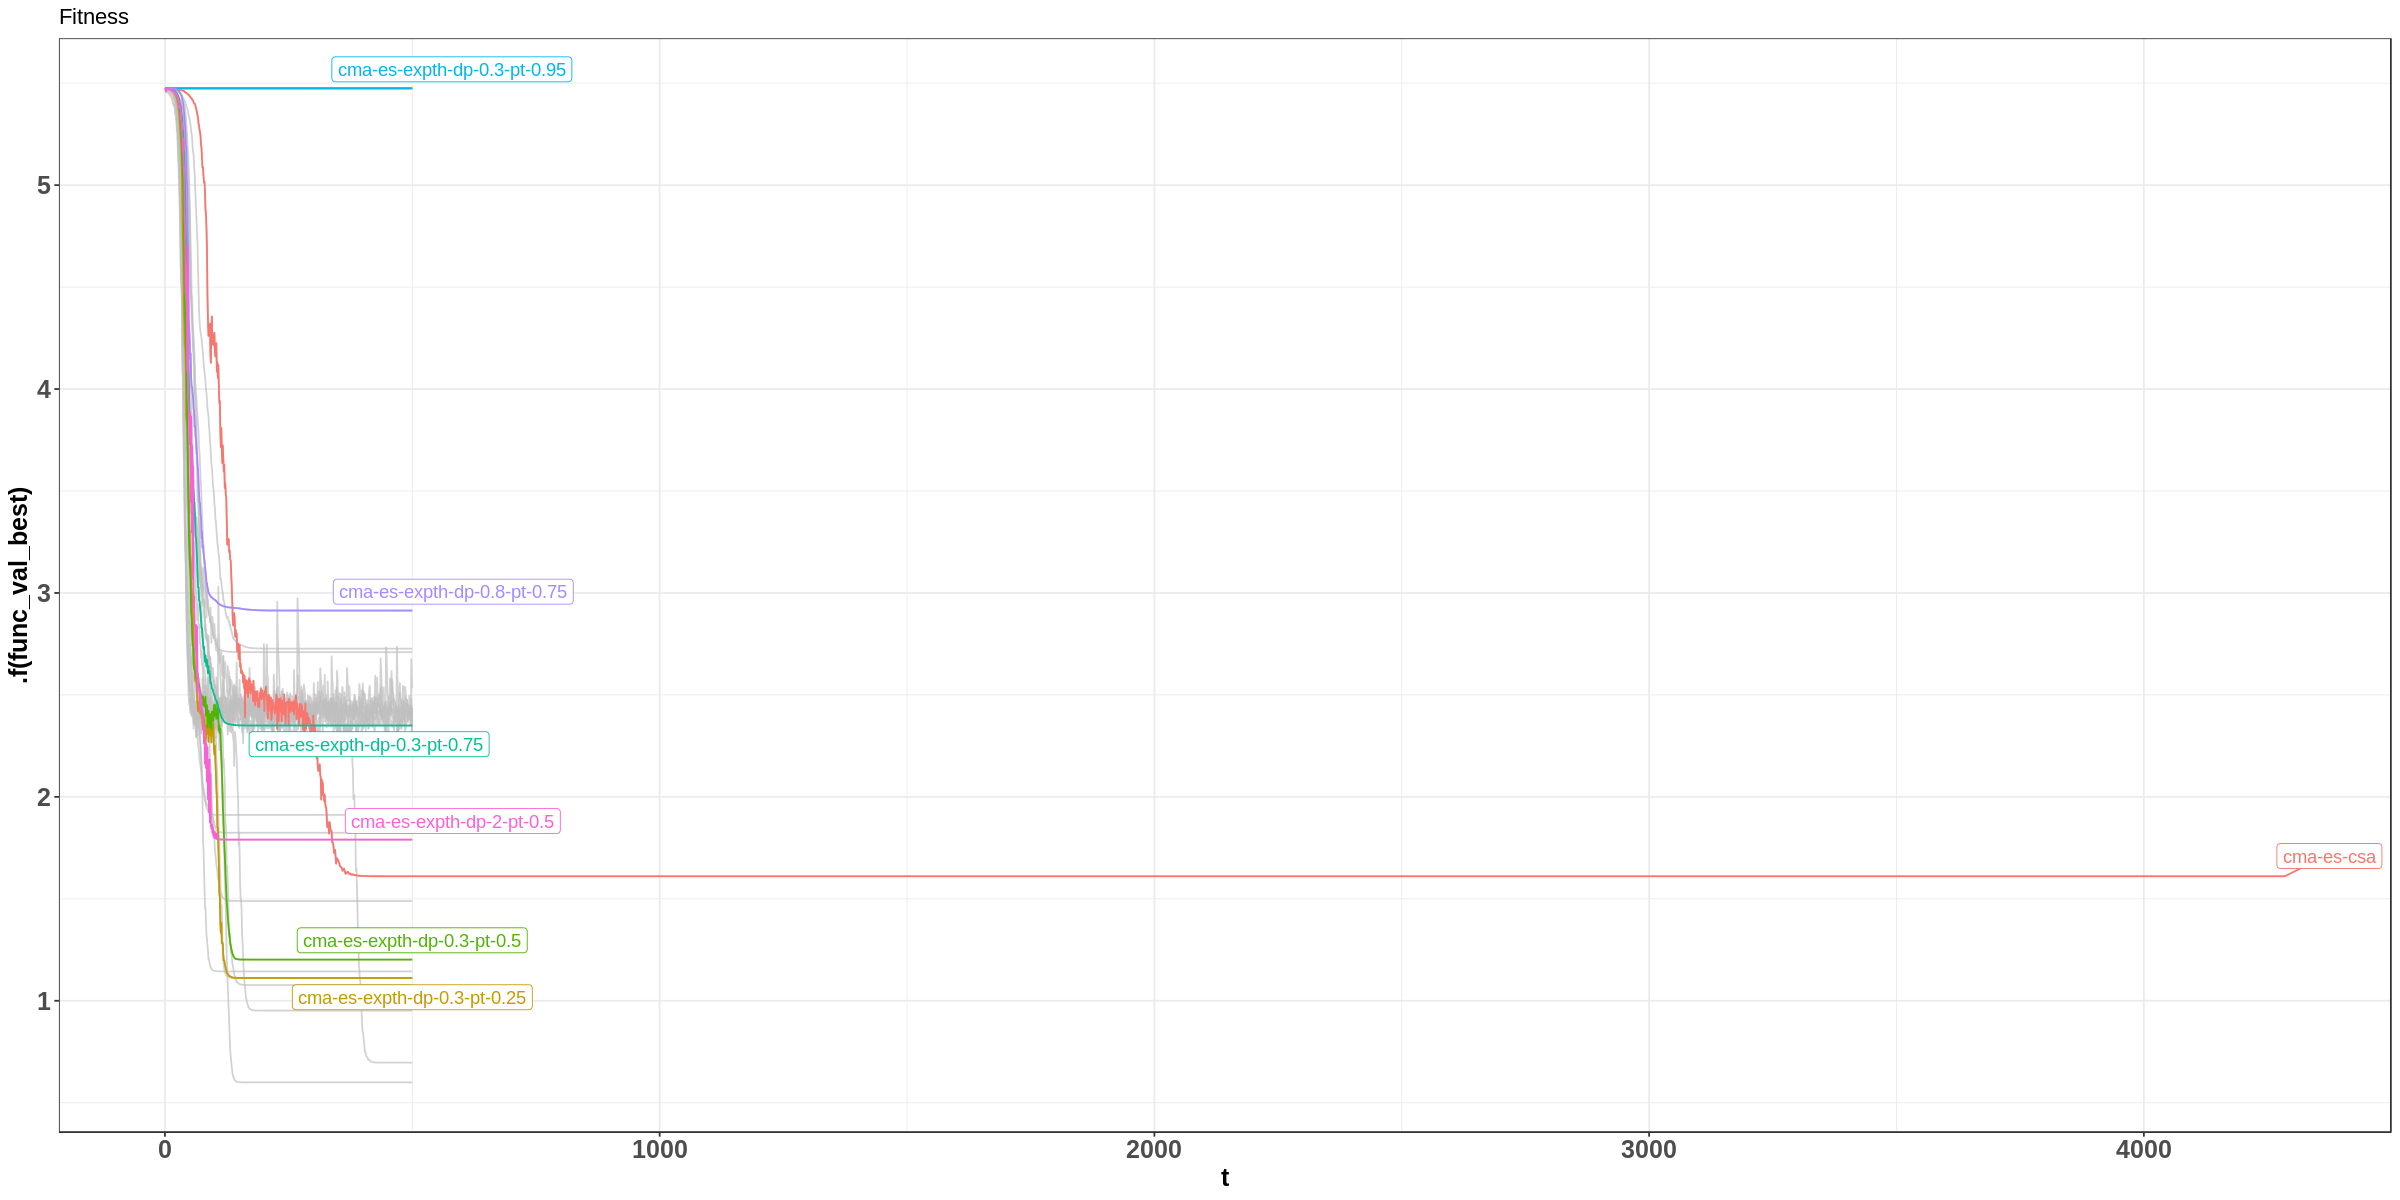

In [98]:
experiments_d30_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-expth-dp-0.3-pt-0.25", "cma-es-csa", "cma-es-expth-dp-0.3-pt-0.95", "cma-es-expth-dp-0.3-pt-0.75", "cma-es-expth-dp-0.3-pt-0.5", "cma-es-expth-dp-2-pt-0.5", "cma-es-expth-dp-0.8-pt-0.75"), use_direct_label = T) 

## const P_target = 0.75 & Func = sphere & Rastrigin
### D_param in (0.1, 0.3, 0.5, 0.8, 0.9, 2)

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


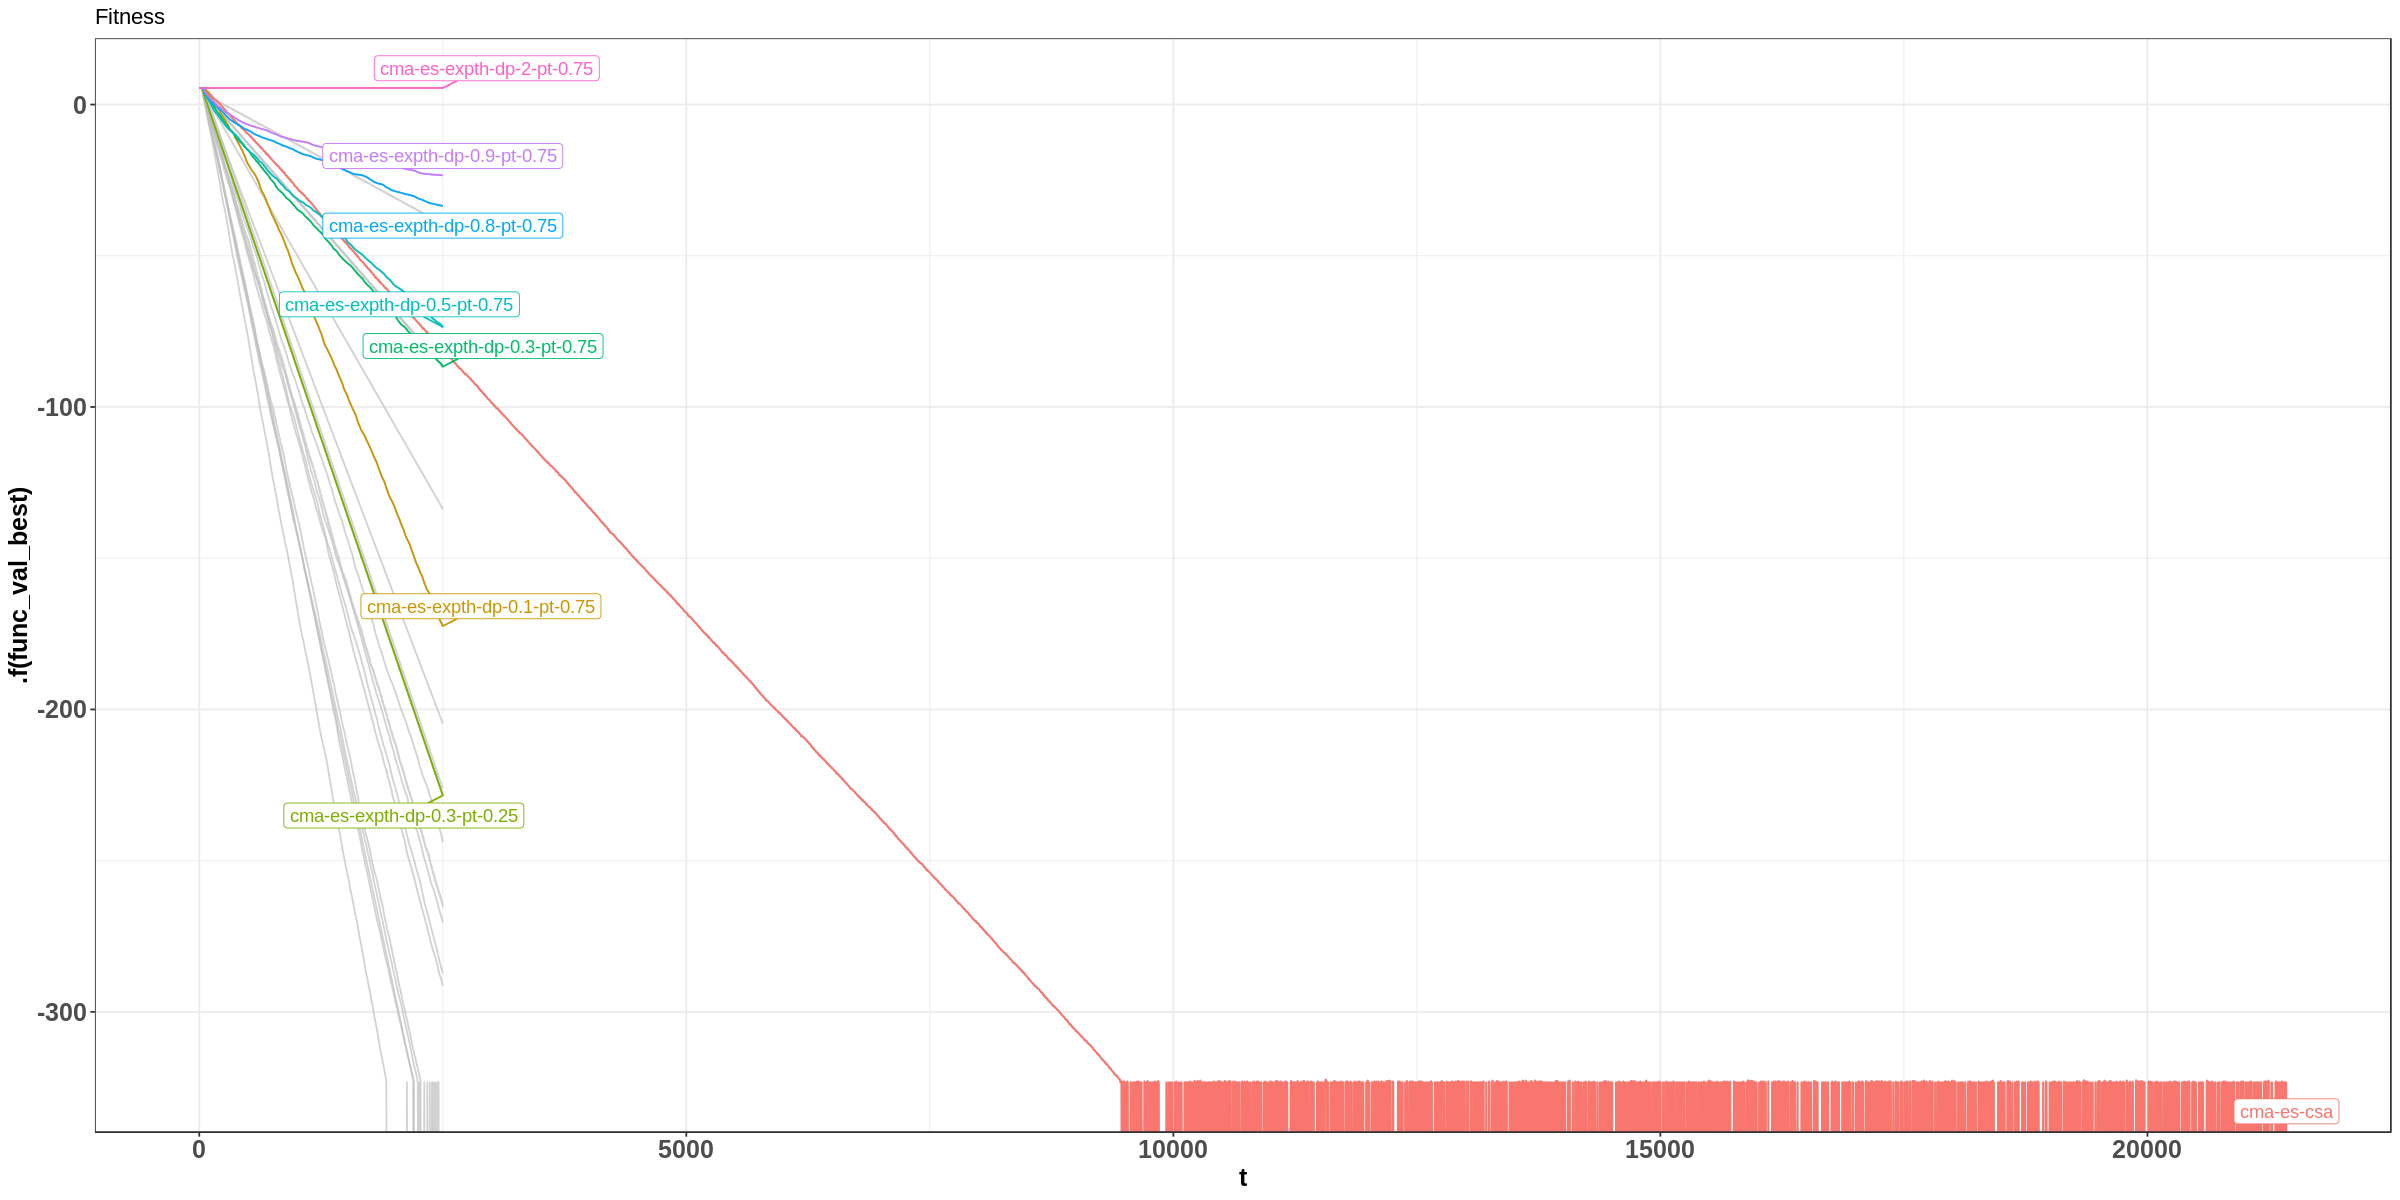

In [111]:
experiments_d30 %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-csa","cma-es-expth-dp-0.3-pt-0.25", "cma-es-expth-dp-0.1-pt-0.75", "cma-es-expth-dp-0.3-pt-0.75", "cma-es-expth-dp-0.5-pt-0.75", "cma-es-expth-dp-0.8-pt-0.75", "cma-es-expth-dp-0.9-pt-0.75", "cma-es-expth-dp-2-pt-0.75"), use_direct_label = T)

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


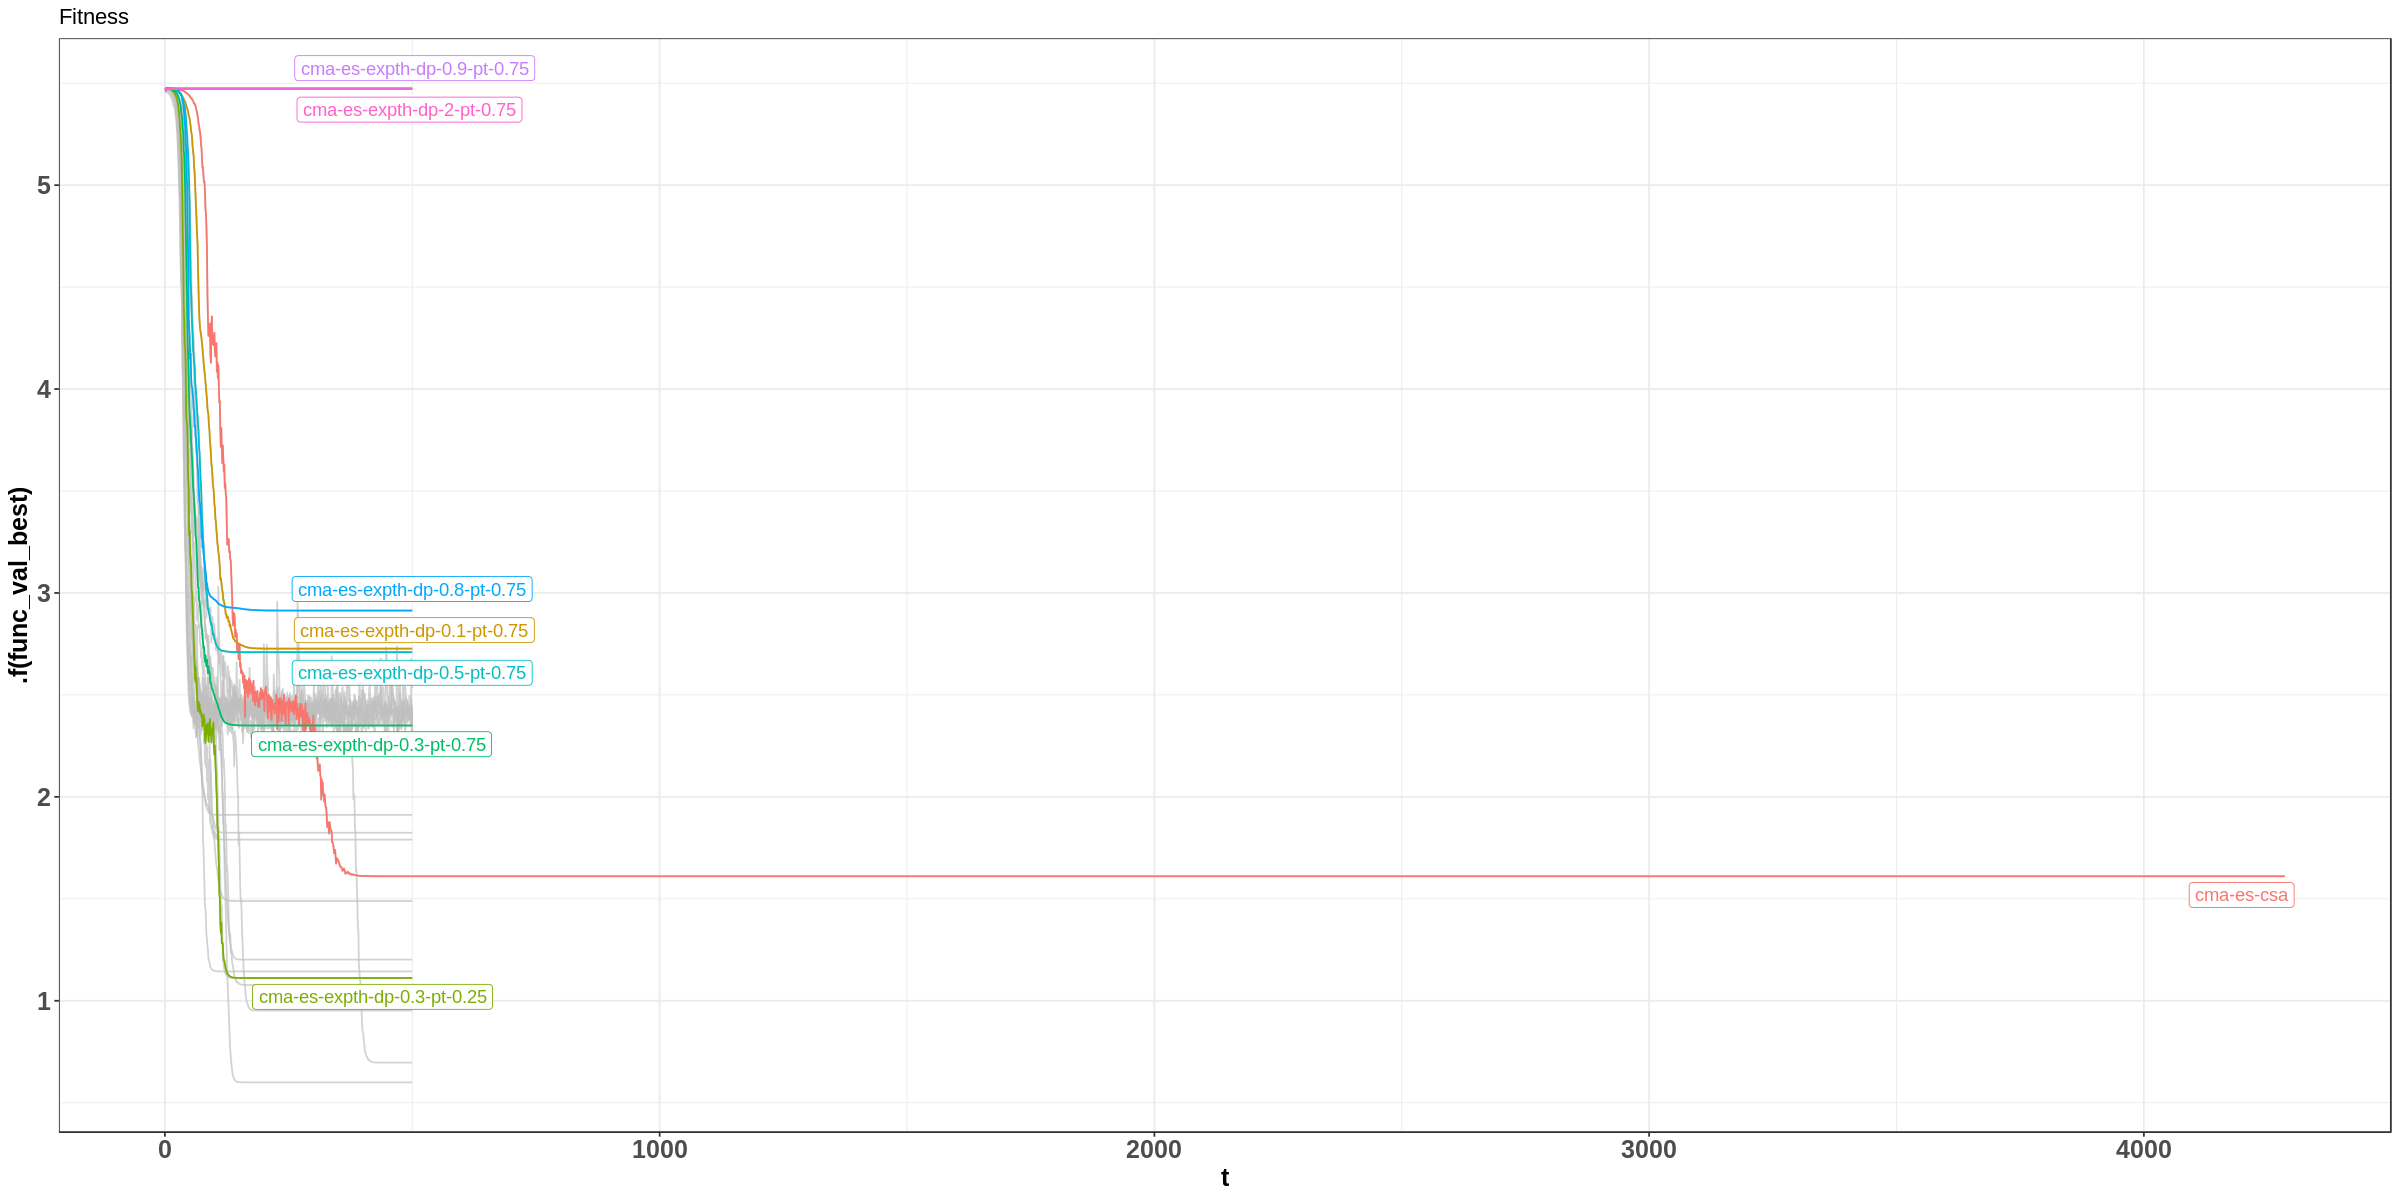

In [110]:
experiments_d30_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-csa", "cma-es-expth-dp-0.3-pt-0.25", "cma-es-expth-dp-0.1-pt-0.75", "cma-es-expth-dp-0.3-pt-0.75", "cma-es-expth-dp-0.5-pt-0.75", "cma-es-expth-dp-0.8-pt-0.75", "cma-es-expth-dp-0.9-pt-0.75", "cma-es-expth-dp-2-pt-0.75"), use_direct_label = T) 

## const P_target = 0.1 & Func = sphere & Rastrigin
### D_param in (0.1, 0.3, 0.5, 0.8, 0.9, 2)

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


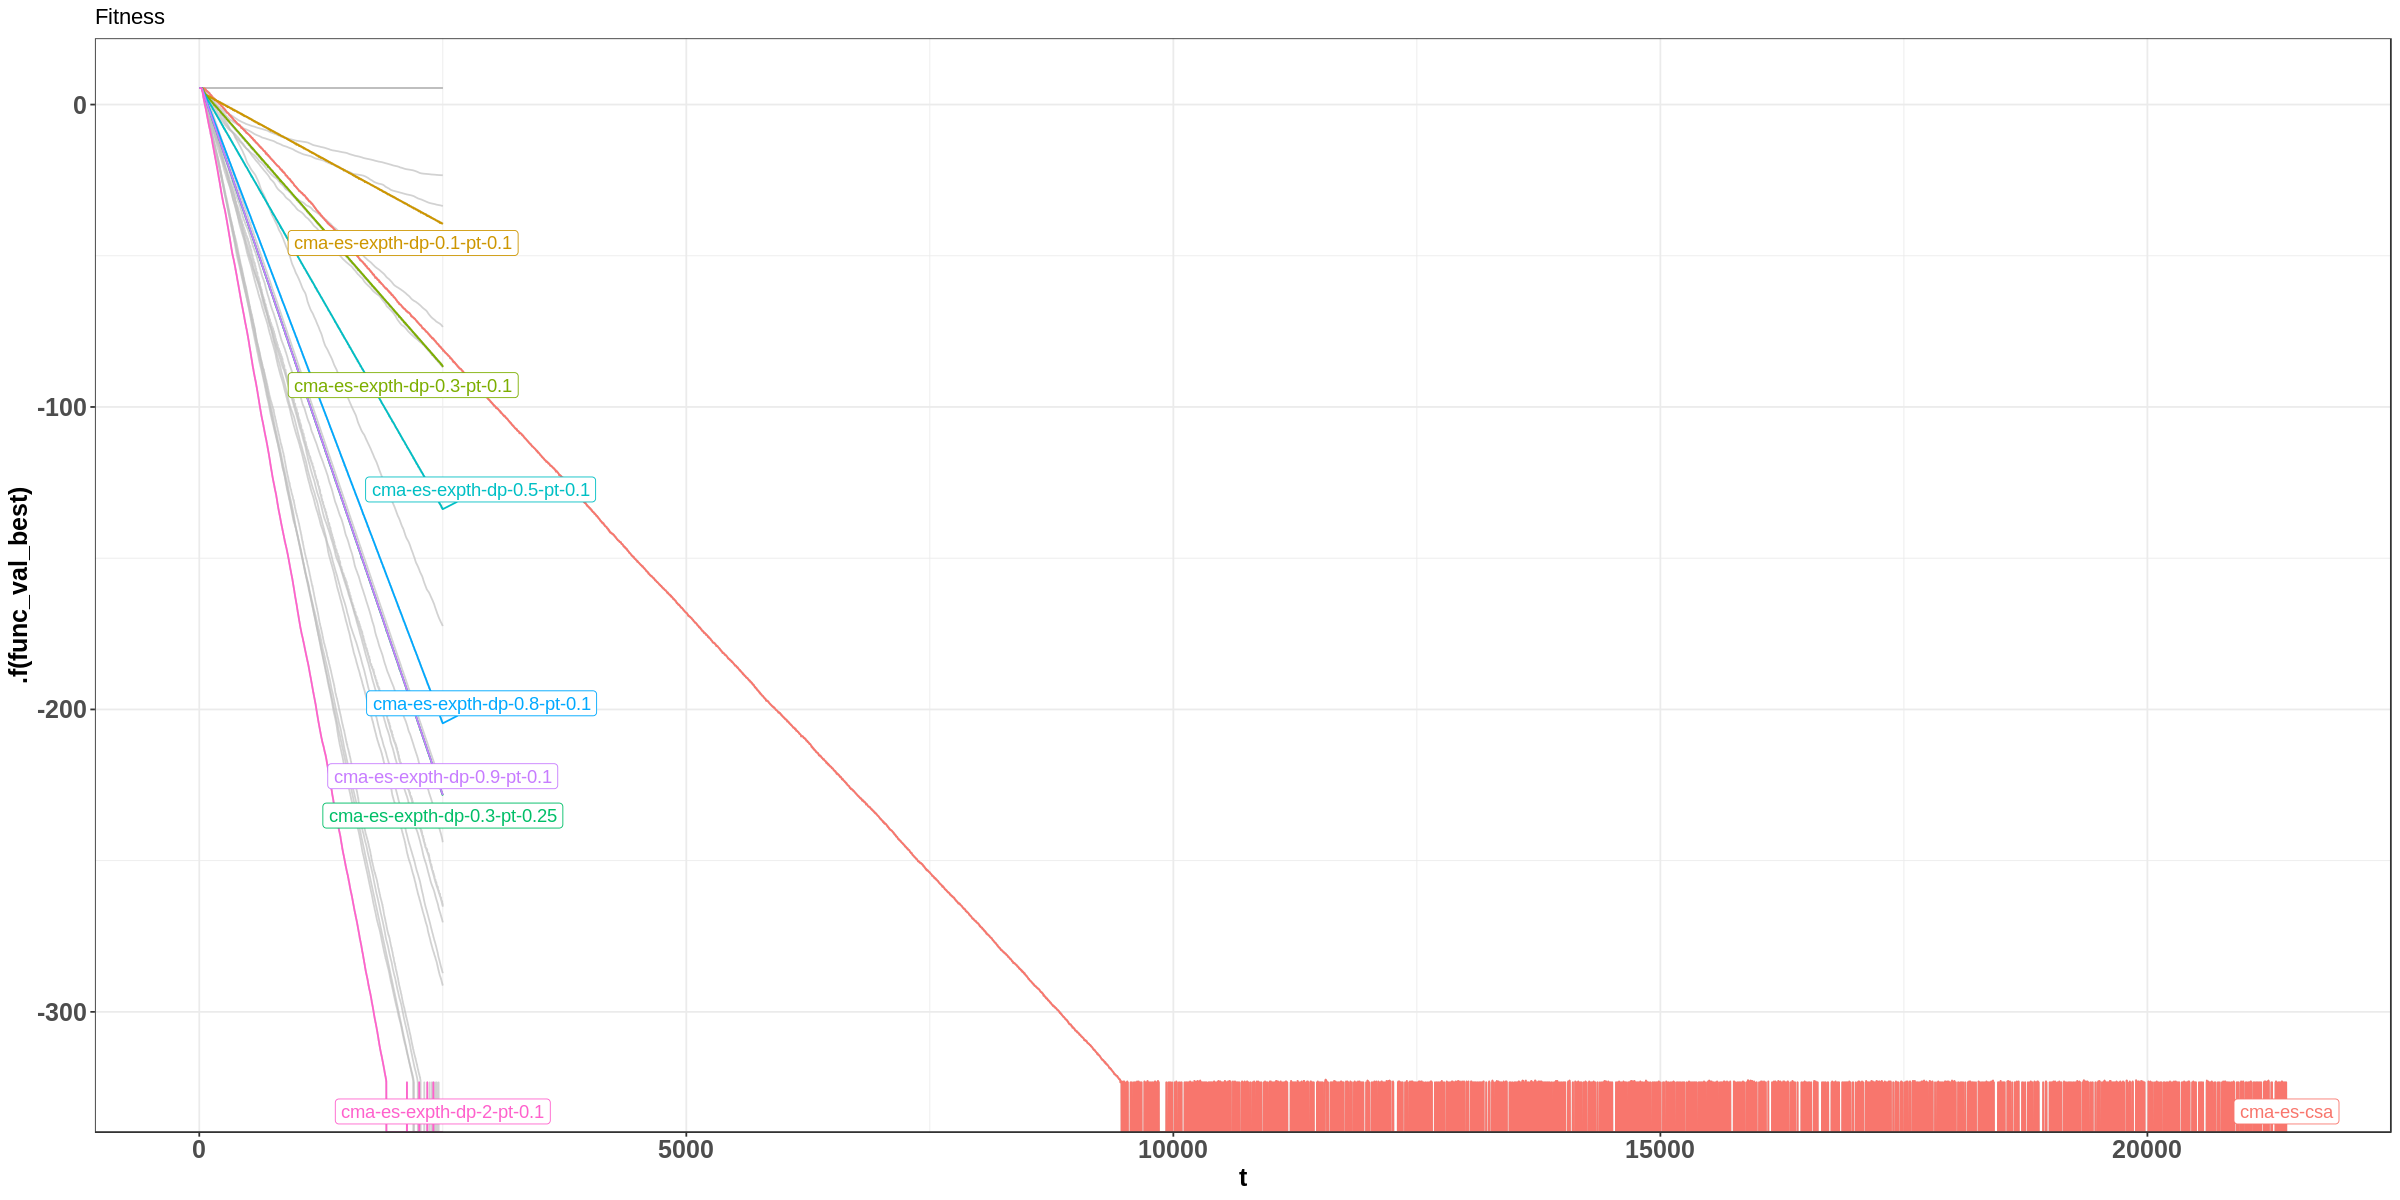

In [112]:
experiments_d30 %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-csa", "cma-es-expth-dp-0.3-pt-0.25", "cma-es-expth-dp-0.1-pt-0.1", "cma-es-expth-dp-0.3-pt-0.1", "cma-es-expth-dp-0.5-pt-0.1", "cma-es-expth-dp-0.8-pt-0.1", "cma-es-expth-dp-0.9-pt-0.1", "cma-es-expth-dp-2-pt-0.1"), use_direct_label = T) 

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”label_key: method


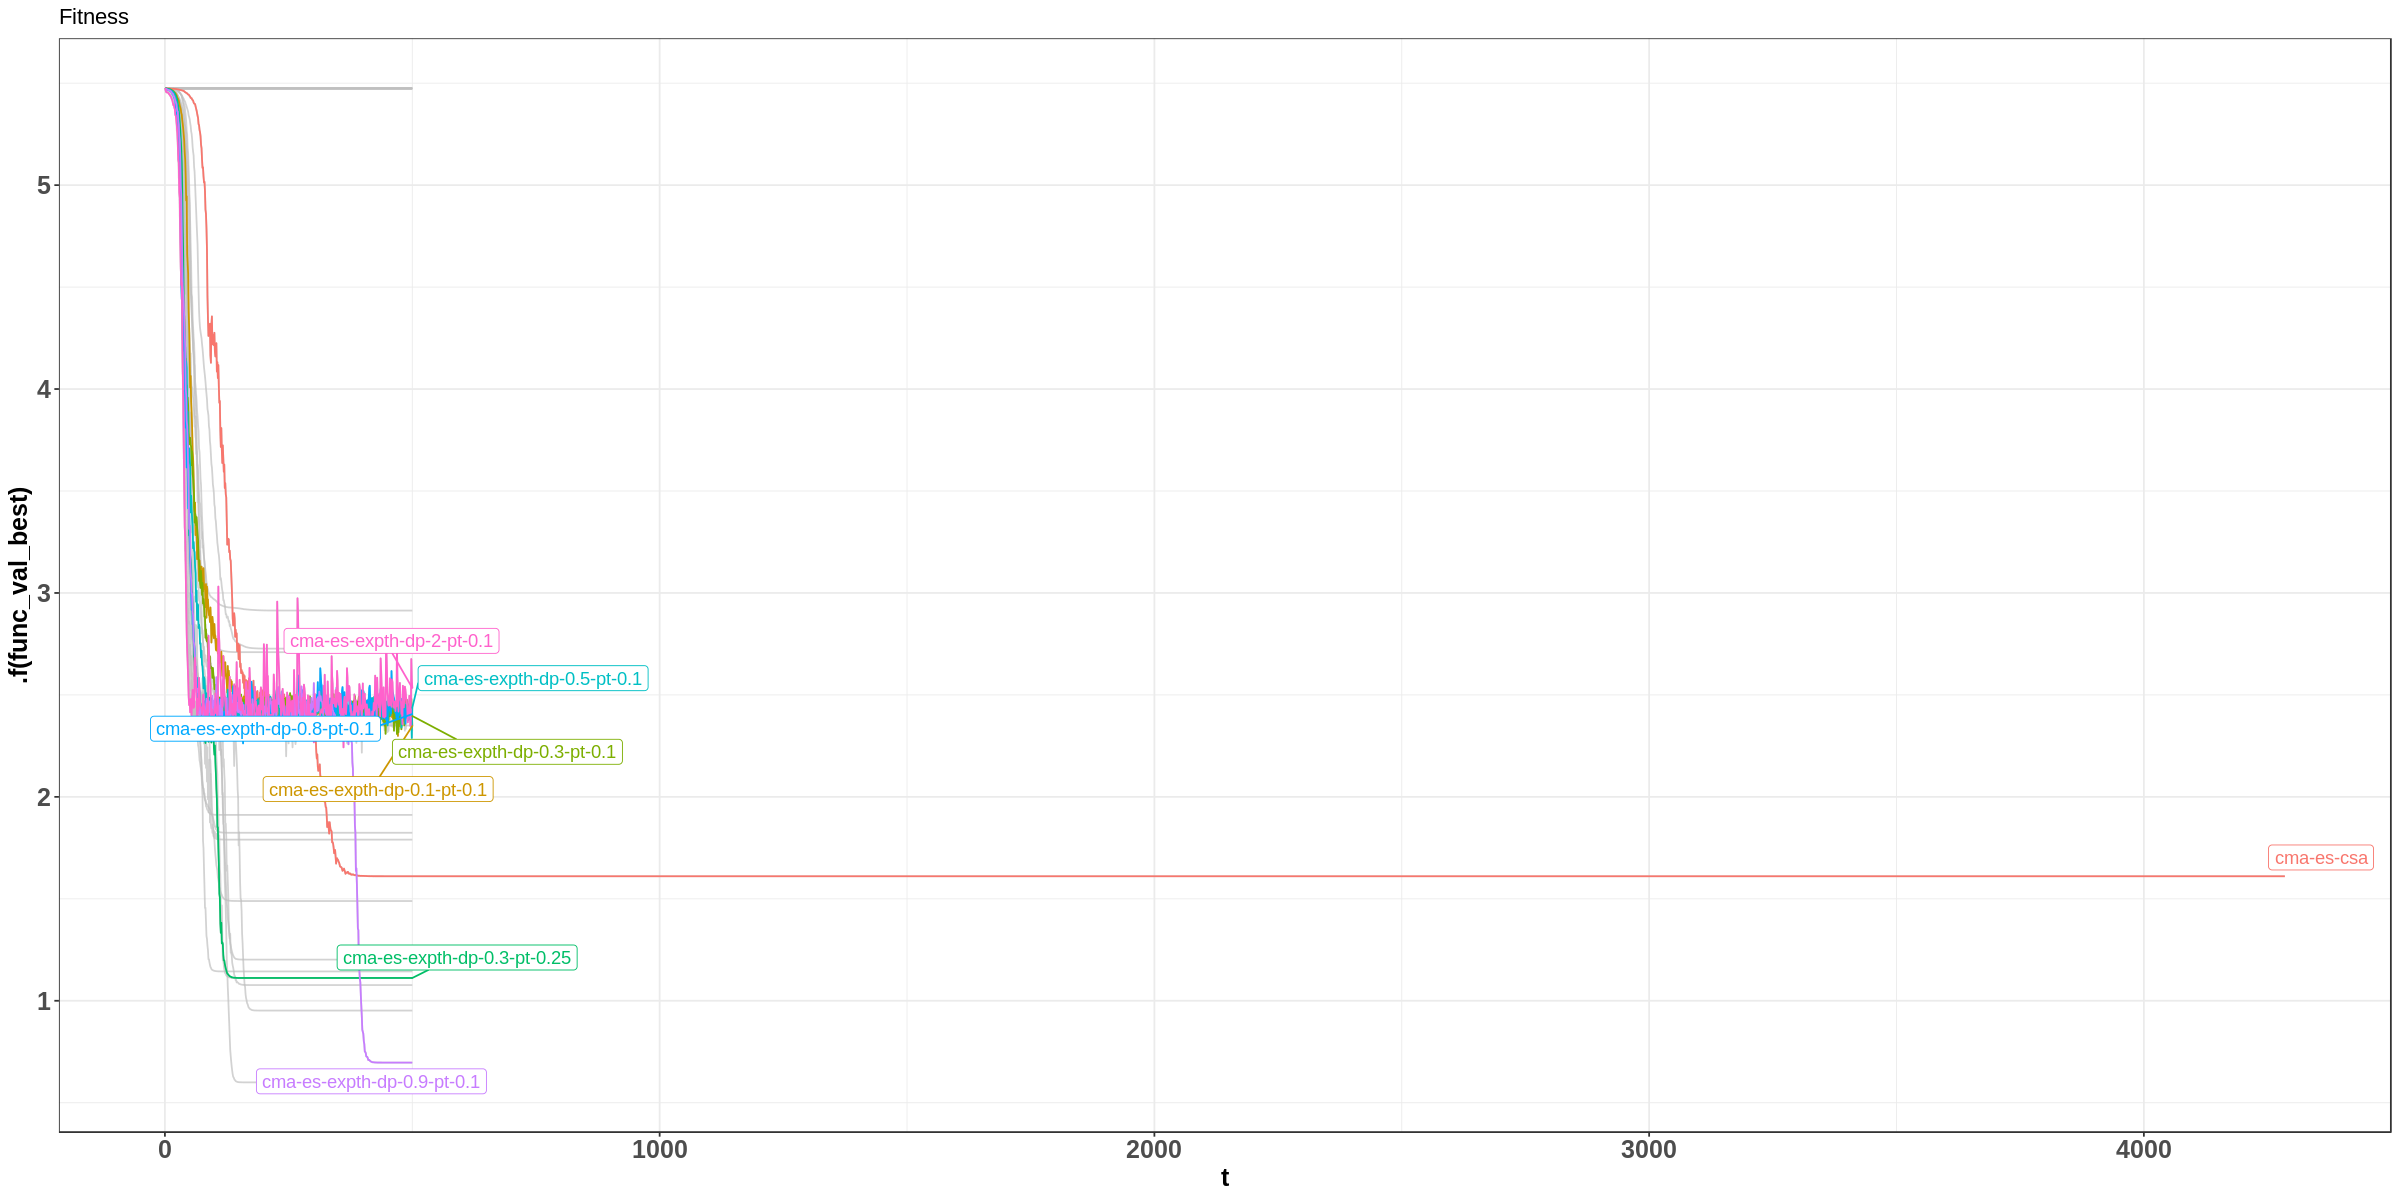

In [113]:
experiments_d30_rastr %>%
    value_plot(.f = log10) +
    gghighlight::gghighlight(method %in% c("cma-es-csa", "cma-es-expth-dp-0.3-pt-0.25", "cma-es-expth-dp-0.1-pt-0.1", "cma-es-expth-dp-0.3-pt-0.1", "cma-es-expth-dp-0.5-pt-0.1", "cma-es-expth-dp-0.8-pt-0.1", "cma-es-expth-dp-0.9-pt-0.1", "cma-es-expth-dp-2-pt-0.1"), use_direct_label = T) 